# Advanced CSP pipelines

This notebook implements more advanced CSP pipelines and tests their performance on the data from the database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211).
The knowledge and utilities obtained from the previous paper notebook 2 and the experimental notebooks four to five are used throughout this notebook.
Due to the small variations in accuracy found between the tested classifiers in the paper notebook 2, we opt to use an LDA approach in this noteboook. 
This has the pro that LDA doesn't actually require hyperparameter tuning, saving a lot of computational time.

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
Baseline correction was done on the first second of the epoch, meaning the second before the visual queue was shown.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.
Alternative experiments include longer windows, such as 1.5 seconds windows.

Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
- Learned filter thresholds
   - Creation of custom SKLearn pipeline component for filter
   - Same subject, same session: LDA classifier
   - Same subject, new session: LDA classifier
   - New subject: LDA classifier
- FBCSP approaches
   - Same subject, same session: LDA classifier
   - Same subject, new session: LDA classifier
   - New subject: LDA classifier

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# IO functions
from IPython.utils import io
import copy

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator,TransformerMixin

# Custom SKlearn components
import custom_sklearn_components
from custom_sklearn_components import EpochsToFilteredData

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

MNE version (1.0.2 recommended): 1.0.2
Scikit-learn version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Matplotlib version (3.5.1 recommended): 3.5.1
Pickle version (4.0 recommended): 4.0


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Learned filter thresholds

The previous paper notebook, notebook `2-standard-csp-pipelines`, made use of a fixed filter aproach, namely an overlap-add FIR filter to obtain the frequencies 2Hz to 32Hz.
These thresholds will be learned in this experiment by using grid search for them, this should fit the frequencies to the subject(s) in question.
To do this, a custom sklearn pipeline component is made from the previously used filter.

<hr>

### Creation of custom SKLearn pipeline component for filter

Since we want to tune the lower and upper bound of the filter using gridsearch, we need to make the filter available as a function that is understood by SKLearn.
This creation is done in the provided util file `custom_sklearn_components`.
The below code block tests its implementation is correct.

In [4]:
####################################################
# TEST FILTER
####################################################

with io.capture_output():
    # Get MNE raw object for latest recording of subject B
    mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= "B")
    # Get epochs for that MNE raw
    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                         start_offset= -1,
                                                         end_offset= 1,
                                                         baseline= (None, 0))
    # mne raw not needed anymore
    del mne_raw
    
    # Only keep epochs from the MI tasks
    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
    # Load epochs into memory
    mne_epochs.load_data()

# Create copies for testing both approaches
manual_conversion = copy.deepcopy(mne_epochs)
automatic_conversion = copy.deepcopy(mne_epochs)

# Do the manuel conversion
with io.capture_output():
    manual_conversion.filter(l_freq= 8,
                      h_freq= 30,
                      picks= "all",
                      phase= "minimum",
                      fir_window= "blackman",
                      fir_design= "firwin",
                      pad= 'median', 
                      n_jobs= -1,
                      verbose= False)
    # Get a half second window
    manual_result = manual_conversion.get_data(tmin=0.1, tmax=0.6)
print(f"Manual conversion gave the following output shape: {np.shape(manual_result)}")

# Do the automatic conversion
automatic_conversion = automatic_conversion.get_data() # Works on data rather then epoch object
custom_filter = EpochsToFilteredData(start_offset = -1,
                                     data_tmin = 0.1,
                                     data_tmax = 0.6,
                                     sfreq= 200,
                                     filter_lower_bound= 8,
                                     filter_upper_bound= 30)
custom_filter.fit(automatic_conversion)
automatic_result = custom_filter.transform(automatic_conversion)
print(f"Automatic conversion gave the following output shape: {np.shape(automatic_result)}")

# Compare results
manual_result = np.array(manual_result)
automatic_result = np.array(automatic_result)
if ((automatic_result.shape == manual_result.shape) and (automatic_result == manual_result).all() ):
    match = True
else:
    match = False
print(f"results are equal: {match}")

# Remove unused variables
del automatic_conversion
del automatic_result
del manual_conversion
del manual_result
del custom_filter
del match
del mne_epochs

Manual conversion gave the following output shape: (960, 21, 100)
Automatic conversion gave the following output shape: (960, 21, 100)
results are equal: True


<hr>

### Same subject, same session: LDA classifier

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last session of each of these participants for training and testing, however, the test set is seperate as to make it 'unseen' data.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The pipeline that is hyperparameter tuned is as follows
         - Filter -> CSP -> LDA
      - The following hyperparameters are tested
         - For the filter:
            - Lower threshold: 1 | 2 | 4 | 6 | 8 | 10 
            - Upper threshold: 26 | 28 | 30 | 32 | 34
         - For CSP:
            - Number of components: 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr
            - When using SVD optimizer, the tol is set to 0.0001, which is the default and was the best for all previous experiments
            - Shrinkage is fixed to None
            - the priors are initialized to a balanced 1/3
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [5]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get the labels
                        labels = mne_epochs.events[:, -1]
                        
                        # Create a test and train split
                        X_train, X_test, y_train, y_test = train_test_split(mne_epochs,
                                                                            labels,
                                                                            test_size = 0.2,
                                                                            shuffle= True,
                                                                            stratify= labels,                                                    
                                                                            random_state= 1998)
                        
                        # make split back to MNE epoch object and then retreive only the data
                        X_train = mne.concatenate_epochs(X_train).get_data()
                        X_test = mne.concatenate_epochs(X_test).get_data()
                        
                
                # Configure the pipeline components by specifying the default parameters
                custom_filter = EpochsToFilteredData(start_offset = -1,
                                                     data_tmin = 0.1,
                                                     data_tmax = 0.6,
                                                     sfreq= 200)
                
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('filter', custom_filter), ('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001],
                               "filter__filter_lower_bound": [1, 2, 4, 6, 8, 10],
                               "filter__filter_upper_bound": [26, 28, 30, 32, 34],
                               },
                              {"CSP__n_components": [4, 6, 10],
                               "LDA__solver": ["lsqr"],
                               "filter__filter_lower_bound": [1, 2, 4, 6, 8, 10],
                               "filter__filter_upper_bound": [26, 28, 30, 32, 34],
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           n_jobs= -1,
                                           return_train_score= True,
                                           error_score="raise")

                # Do the grid search on the training data
                grid_search.fit(X= X_train, y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/3/samesubject_samesession/subject{subject_id}/gridsearch_autofreqcsplda.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/3/samesubject_samesession/subject{subject_id}/testdata-x_autofreqcsplda.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/3/samesubject_samesession/subject{subject_id}/testdata-y_autofreqcsplda.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/3/samesubject_samesession/subject{subject_id}/traindata-x_autofreqcsplda.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/3/samesubject_samesession/subject{subject_id}/traindata-y_autofreqcsplda.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del csp
                del lda
                del custom_filter
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

Remember the old results, where a fixed filter from 2Hz to 32Hz was used.

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

The autofreq results are as follows:

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                                              |
|-------------|------------------------------------------|------------------------------------|-------------------------------------------------------------------------|
| B           | 0.6615 +- 0.0301                         | 0.6042                             | 2 - 30 Hz filter \| 4 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7171 +- 0.0349                         | 0.7188                             | 2 - 30 Hz filter \| 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7592 +- 0.0098                         | 0.7382                             | 1 - 34 Hz filter \| 10 CSP components \| LDA SVD solver with 0.0001 tol |

As you can see, the found frequencies are very close to the fixed ones in the previous experiments.
As such, the results are near identical.


In [6]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/3/samesubject_samesession/subject{subject_id}/gridsearch_autofreqcsplda.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.6615 +- 0.0301 with the following parameters
{'CSP__n_components': 4, 'LDA__solver': 'svd', 'LDA__tol': 0.0001, 'filter__filter_lower_bound': 2, 'filter__filter_upper_bound': 30}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
97,6.929601,0.024191,1.677718,0.012865,4,lsqr,NaN,2,30,0.614583,...,0.661458,0.661458,0.030145,1,0.697917,0.663194,0.690972,0.685764,0.684462,0.013014
7,7.234303,0.042623,1.735185,0.013001,4,svd,0.0001,2,30,0.614583,...,0.661458,0.661458,0.030145,1,0.699653,0.663194,0.690972,0.685764,0.684896,0.013476
9,6.980732,0.032833,1.669521,0.011816,4,svd,0.0001,2,34,0.614583,...,0.661458,0.661458,0.029232,1,0.699653,0.668403,0.687500,0.685764,0.685330,0.011142
99,6.909652,0.055929,1.688581,0.016322,4,lsqr,NaN,2,34,0.614583,...,0.661458,0.661458,0.029232,1,0.699653,0.668403,0.687500,0.685764,0.685330,0.011142
38,6.890080,0.032859,1.688769,0.017455,6,svd,0.0001,2,32,0.578125,...,0.692708,0.661458,0.050362,1,0.722222,0.684028,0.689236,0.696181,0.697917,0.014680
128,6.933795,0.051135,1.675758,0.015507,6,lsqr,NaN,2,32,0.578125,...,0.692708,0.661458,0.050362,1,0.720486,0.682292,0.689236,0.696181,0.697049,0.014395
98,6.924288,0.043146,1.663135,0.007487,4,lsqr,NaN,2,32,0.614583,...,0.661458,0.660156,0.028616,7,0.697917,0.666667,0.694444,0.684028,0.685764,0.012153
37,6.931531,0.050128,1.690613,0.011985,6,svd,0.0001,2,30,0.572917,...,0.697917,0.660156,0.053290,7,0.713542,0.685764,0.687500,0.697917,0.696181,0.011049
8,7.243184,0.036910,2.145128,0.023633,4,svd,0.0001,2,32,0.614583,...,0.661458,0.660156,0.028616,7,0.699653,0.666667,0.694444,0.684028,0.686198,0.012602
127,6.961507,0.025327,1.679325,0.013540,6,lsqr,NaN,2,30,0.572917,...,0.697917,0.660156,0.053290,7,0.711806,0.685764,0.687500,0.697917,0.695747,0.010371




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
55,4.936955,0.013664,1.015189,0.010331,6,svd,0.0001,10,26,0.333333,...,0.359375,0.354167,0.015185,171,0.515625,0.536458,0.536458,0.531250,0.529948,0.008538
110,6.931586,0.056879,1.663849,0.013257,4,lsqr,NaN,8,26,0.338542,...,0.380208,0.352865,0.017027,172,0.482639,0.484375,0.517361,0.477431,0.490451,0.015745
22,6.898534,0.108244,1.752951,0.045159,4,svd,0.0001,8,30,0.354167,...,0.348958,0.352865,0.018552,172,0.472222,0.496528,0.529514,0.482639,0.495226,0.021593
20,6.888580,0.074617,1.677523,0.008107,4,svd,0.0001,8,26,0.338542,...,0.380208,0.352865,0.017027,172,0.482639,0.484375,0.517361,0.477431,0.490451,0.015745
145,4.947901,0.054458,1.010179,0.010473,6,lsqr,NaN,10,26,0.333333,...,0.354167,0.352865,0.014903,172,0.513889,0.536458,0.538194,0.529514,0.529514,0.009588
112,6.909941,0.047775,1.668187,0.009028,4,lsqr,NaN,8,30,0.354167,...,0.348958,0.351562,0.020339,176,0.473958,0.496528,0.529514,0.482639,0.495660,0.021139
116,4.957367,0.036559,1.018948,0.008036,4,lsqr,NaN,10,28,0.328125,...,0.359375,0.347656,0.011863,177,0.480903,0.531250,0.520833,0.508681,0.510417,0.018819
26,4.917077,0.025708,1.016930,0.012516,4,svd,0.0001,10,28,0.322917,...,0.359375,0.346354,0.014024,178,0.480903,0.531250,0.520833,0.508681,0.510417,0.018819
115,4.949808,0.026669,1.030920,0.013869,4,lsqr,NaN,10,26,0.302083,...,0.338542,0.332031,0.017806,179,0.470486,0.520833,0.517361,0.486111,0.498698,0.021170
25,4.947645,0.028567,1.035745,0.031736,4,svd,0.0001,10,26,0.302083,...,0.338542,0.332031,0.017806,179,0.468750,0.519097,0.519097,0.486111,0.498264,0.021719




In total there are 180 different configurations tested.
The best mean test score is 0.6615
There are 6 configurations with this maximum score
There are 27 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,27.000000,27.000000,27.000000,27.000000,27.0,27,13.0000,27.0,27.0,27.000000,...,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
unique,NaN,NaN,NaN,NaN,3.0,2,1.0000,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,4.0,lsqr,0.0001,2.0,30.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,10.0,14,13.0000,27.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.997512,0.041916,1.707237,0.016215,NaN,NaN,NaN,NaN,NaN,0.595100,...,0.669560,0.655720,0.037886,12.592593,0.713156,0.693801,0.696116,0.697659,0.700183,0.012867
std,0.176417,0.023382,0.096994,0.008395,NaN,NaN,NaN,NaN,NaN,0.015797,...,0.019182,0.006573,0.009768,8.621348,0.015290,0.035730,0.012459,0.015240,0.018957,0.001835
min,6.877007,0.011135,1.663135,0.003871,NaN,NaN,NaN,NaN,NaN,0.572917,...,0.635417,0.641927,0.027406,1.000000,0.687500,0.657986,0.684028,0.682292,0.679253,0.009627
25%,6.924073,0.026520,1.671844,0.011456,NaN,NaN,NaN,NaN,NaN,0.578125,...,0.653646,0.651042,0.029319,7.000000,0.699653,0.666667,0.687500,0.685764,0.685330,0.011309
50%,6.934037,0.036910,1.681709,0.013997,NaN,NaN,NaN,NaN,NaN,0.598958,...,0.661458,0.658854,0.031974,11.000000,0.717014,0.682292,0.690972,0.694444,0.696181,0.012897
75%,6.962729,0.047918,1.689305,0.018026,NaN,NaN,NaN,NaN,NaN,0.609375,...,0.687500,0.660156,0.050362,20.500000,0.725694,0.715278,0.702257,0.708333,0.713108,0.014046





####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.7171 +- 0.0349 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001, 'filter__filter_lower_bound': 2, 'filter__filter_upper_bound': 30}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
157,6.930289,0.051318,1.674216,0.013695,10,lsqr,NaN,2,30,0.760417,...,0.696335,0.717053,0.034851,1,0.773913,0.718261,0.760000,0.756944,0.752280,0.020656
67,6.896300,0.065509,1.675466,0.013688,10,svd,0.0001,2,30,0.760417,...,0.696335,0.717053,0.034851,1,0.773913,0.718261,0.760000,0.758681,0.752714,0.020767
36,6.941286,0.069031,1.683463,0.016396,6,svd,0.0001,2,28,0.744792,...,0.743455,0.714510,0.033939,3,0.768696,0.713043,0.751304,0.746528,0.744893,0.020154
126,6.988521,0.117986,1.704706,0.068980,6,lsqr,NaN,2,28,0.744792,...,0.743455,0.714510,0.033939,3,0.770435,0.713043,0.751304,0.746528,0.745328,0.020675
68,6.929789,0.039528,1.668217,0.009855,10,svd,0.0001,2,32,0.755208,...,0.691099,0.714442,0.034098,5,0.772174,0.718261,0.751304,0.756944,0.749671,0.019676
158,6.940536,0.065779,1.690961,0.013933,10,lsqr,NaN,2,32,0.755208,...,0.691099,0.714442,0.034098,5,0.772174,0.718261,0.753043,0.756944,0.750106,0.019726
35,6.892301,0.073782,1.685713,0.019492,6,svd,0.0001,2,26,0.750000,...,0.738220,0.713201,0.038223,7,0.768696,0.711304,0.751304,0.751736,0.745760,0.021093
125,6.915044,0.058039,1.669467,0.011110,6,lsqr,NaN,2,26,0.750000,...,0.738220,0.713201,0.038223,7,0.768696,0.711304,0.751304,0.751736,0.745760,0.021093
65,6.894550,0.069961,1.687462,0.010170,10,svd,0.0001,2,26,0.755208,...,0.706806,0.713160,0.029766,9,0.782609,0.723478,0.760000,0.758681,0.756192,0.021147
155,6.949033,0.048612,1.664469,0.019780,10,lsqr,NaN,2,26,0.755208,...,0.706806,0.713160,0.029766,9,0.782609,0.723478,0.760000,0.758681,0.756192,0.021147




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
3,5.987340,0.021895,1.442290,0.011095,4,svd,0.0001,1,32,0.447917,...,0.502618,0.507165,0.037348,171,0.500870,0.546087,0.584348,0.564236,0.548885,0.030849
93,6.000586,0.037308,1.410050,0.018789,4,lsqr,NaN,1,32,0.447917,...,0.502618,0.507165,0.037348,171,0.500870,0.546087,0.584348,0.564236,0.548885,0.030849
2,5.985841,0.044587,1.439042,0.006576,4,svd,0.0001,1,30,0.442708,...,0.497382,0.507158,0.042208,173,0.499130,0.540870,0.560000,0.565972,0.541493,0.026157
92,5.996587,0.037542,1.408051,0.019519,4,lsqr,NaN,1,30,0.442708,...,0.497382,0.507158,0.042208,173,0.499130,0.540870,0.560000,0.565972,0.541493,0.026157
1,5.952601,0.034605,1.431794,0.008072,4,svd,0.0001,1,28,0.437500,...,0.502618,0.505863,0.043200,175,0.497391,0.535652,0.558261,0.564236,0.538885,0.026222
0,6.038826,0.050281,1.473780,0.014354,4,svd,0.0001,1,26,0.437500,...,0.502618,0.505863,0.042726,175,0.485217,0.539130,0.558261,0.559028,0.535409,0.030055
90,5.994339,0.058532,1.417298,0.017073,4,lsqr,NaN,1,26,0.437500,...,0.502618,0.505863,0.042726,175,0.485217,0.539130,0.558261,0.557292,0.534975,0.029721
91,5.986591,0.054133,1.412549,0.019679,4,lsqr,NaN,1,28,0.437500,...,0.502618,0.505863,0.043200,175,0.497391,0.535652,0.558261,0.564236,0.538885,0.026222
4,5.987090,0.025701,1.425296,0.006337,4,svd,0.0001,1,34,0.453125,...,0.502618,0.504561,0.032126,179,0.506087,0.537391,0.584348,0.557292,0.546279,0.028570
94,5.991089,0.033945,1.418798,0.023692,4,lsqr,NaN,1,34,0.453125,...,0.502618,0.504561,0.032126,179,0.506087,0.535652,0.584348,0.559028,0.546279,0.028897




In total there are 180 different configurations tested.
The best mean test score is 0.7171
There are 2 configurations with this maximum score
There are 20 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,20.000000,20.000000,20.000000,20.000000,20.0,20,10.0000,20.0,20.0,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
unique,NaN,NaN,NaN,NaN,2.0,2,1.0000,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,lsqr,0.0001,2.0,30.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,10.0,10,10.0000,20.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.934076,0.060630,1.677902,0.015824,NaN,NaN,NaN,NaN,NaN,0.749479,...,0.716754,0.711480,0.033595,10.100000,0.772435,0.717478,0.753913,0.753559,0.749346,0.020105
std,0.028982,0.024944,0.010501,0.013770,NaN,NaN,NaN,NaN,NaN,0.006069,...,0.020447,0.003943,0.003045,6.025385,0.007121,0.007474,0.004088,0.009298,0.006172,0.002557
min,6.892301,0.023213,1.664469,0.003741,NaN,NaN,NaN,NaN,NaN,0.739583,...,0.685864,0.704018,0.027642,1.000000,0.765217,0.709565,0.749565,0.741319,0.741852,0.013422
25%,6.914982,0.046263,1.668092,0.009587,NaN,NaN,NaN,NaN,NaN,0.744792,...,0.696335,0.708962,0.032163,5.000000,0.766957,0.711304,0.751304,0.744792,0.743807,0.020047
50%,6.930914,0.060239,1.679214,0.013619,NaN,NaN,NaN,NaN,NaN,0.750000,...,0.719895,0.712526,0.034056,10.000000,0.770435,0.715652,0.751304,0.754340,0.747716,0.020482
75%,6.949721,0.070916,1.683650,0.017170,NaN,NaN,NaN,NaN,NaN,0.755208,...,0.732984,0.714442,0.034851,15.250000,0.773913,0.723478,0.758696,0.758681,0.755865,0.021093





####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.7592 +- 0.0098 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001, 'filter__filter_lower_bound': 1, 'filter__filter_upper_bound': 34}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
154,6.011744,0.037381,1.421694,0.019715,10,lsqr,NaN,1,34,0.769634,...,0.759162,0.759162,0.009795,1,0.794066,0.776614,0.780105,0.808028,0.789703,0.012433
64,6.029175,0.036718,1.403362,0.022508,10,svd,0.0001,1,34,0.769634,...,0.759162,0.759162,0.009795,1,0.794066,0.776614,0.780105,0.804538,0.788831,0.011175
63,5.990848,0.051658,1.409371,0.017801,10,svd,0.0001,1,32,0.769634,...,0.743455,0.757853,0.010054,3,0.797557,0.767888,0.778360,0.804538,0.787086,0.014653
153,5.973636,0.036899,1.417303,0.014773,10,lsqr,NaN,1,32,0.764398,...,0.743455,0.756545,0.008682,4,0.795812,0.767888,0.778360,0.802792,0.786213,0.013825
152,6.032101,0.062169,1.420119,0.010985,10,lsqr,NaN,1,30,0.764398,...,0.753927,0.751309,0.014097,5,0.801047,0.776614,0.778360,0.804538,0.790140,0.012728
62,6.033682,0.034148,1.414236,0.009872,10,svd,0.0001,1,30,0.764398,...,0.753927,0.751309,0.014097,5,0.801047,0.776614,0.778360,0.804538,0.790140,0.012728
60,6.036146,0.031938,1.407580,0.013931,10,svd,0.0001,1,26,0.748691,...,0.743455,0.746073,0.009439,7,0.785340,0.790576,0.771379,0.788831,0.784031,0.007544
150,5.999882,0.047161,1.403367,0.009566,10,lsqr,NaN,1,26,0.753927,...,0.743455,0.746073,0.011996,7,0.785340,0.788831,0.771379,0.788831,0.783595,0.007196
61,6.022441,0.032891,1.411070,0.010919,10,svd,0.0001,1,28,0.753927,...,0.738220,0.743455,0.017755,9,0.792321,0.794066,0.771379,0.799302,0.789267,0.010643
151,6.008069,0.046000,1.408804,0.013086,10,lsqr,NaN,1,28,0.753927,...,0.738220,0.743455,0.017755,9,0.792321,0.794066,0.769634,0.799302,0.788831,0.011377




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
140,6.890181,0.058288,1.660033,0.016173,6,lsqr,NaN,8,26,0.565445,...,0.649215,0.607330,0.050354,170,0.678883,0.619546,0.680628,0.675393,0.663613,0.025511
50,6.872767,0.050315,1.667357,0.015109,6,svd,0.0001,8,26,0.565445,...,0.649215,0.607330,0.050354,170,0.678883,0.621291,0.680628,0.675393,0.664049,0.024758
45,6.872235,0.036162,1.678407,0.021782,6,svd,0.0001,6,26,0.617801,...,0.623037,0.606021,0.018278,173,0.684119,0.668412,0.673647,0.659686,0.671466,0.008845
48,6.884603,0.037001,1.650727,0.001998,6,svd,0.0001,6,32,0.607330,...,0.591623,0.606021,0.014036,173,0.654450,0.675393,0.684119,0.630017,0.660995,0.020883
20,6.891279,0.015019,1.660524,0.008169,4,svd,0.0001,8,26,0.596859,...,0.649215,0.604712,0.039441,175,0.619546,0.616056,0.650960,0.626527,0.628272,0.013630
110,6.888317,0.018083,1.652932,0.016827,4,lsqr,NaN,8,26,0.596859,...,0.649215,0.603403,0.038718,176,0.619546,0.616056,0.650960,0.626527,0.628272,0.013630
19,6.883498,0.010677,1.657418,0.002950,4,svd,0.0001,6,34,0.607330,...,0.602094,0.600785,0.005705,177,0.640489,0.652705,0.661431,0.589878,0.636126,0.027718
109,6.877677,0.019938,1.645094,0.005830,4,lsqr,NaN,6,34,0.607330,...,0.602094,0.600785,0.005705,177,0.638743,0.650960,0.661431,0.589878,0.635253,0.027400
108,6.912820,0.039014,1.669850,0.020484,4,lsqr,NaN,6,32,0.581152,...,0.617801,0.596859,0.013348,179,0.630017,0.656195,0.661431,0.607330,0.638743,0.021693
18,6.884649,0.048689,1.670402,0.010750,4,svd,0.0001,6,32,0.581152,...,0.617801,0.596859,0.013348,179,0.630017,0.656195,0.661431,0.605585,0.638307,0.022328




In total there are 180 different configurations tested.
The best mean test score is 0.7592
There are 2 configurations with this maximum score
There are 10 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,10.000000,10.000000,10.000000,10.000000,10.0,10,5.0000,10.0,10.0,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
unique,NaN,NaN,NaN,NaN,1.0,2,1.0000,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,lsqr,0.0001,1.0,34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,10.0,5,5.0000,10.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.013772,0.041696,1.411691,0.014316,NaN,NaN,NaN,NaN,NaN,0.761257,...,0.747644,0.751440,0.012346,5.100000,0.793892,0.780977,0.775742,0.800524,0.787784,0.011430
std,0.020847,0.009792,0.006487,0.004412,NaN,NaN,NaN,NaN,NaN,0.007882,...,0.008111,0.006426,0.003414,2.923088,0.005485,0.010084,0.004215,0.006686,0.002444,0.002454
min,5.973636,0.031938,1.403362,0.009566,NaN,NaN,NaN,NaN,NaN,0.748691,...,0.738220,0.743455,0.008682,1.000000,0.785340,0.767888,0.769634,0.788831,0.783595,0.007196
25%,6.001928,0.034790,1.407886,0.010936,NaN,NaN,NaN,NaN,NaN,0.753927,...,0.743455,0.746073,0.009795,3.250000,0.792321,0.776614,0.771379,0.799302,0.786431,0.010776
50%,6.017093,0.037140,1.410220,0.013508,NaN,NaN,NaN,NaN,NaN,0.764398,...,0.743455,0.751309,0.011025,5.000000,0.794066,0.776614,0.778360,0.803665,0.788831,0.011905
75%,6.031369,0.046870,1.416536,0.017044,NaN,NaN,NaN,NaN,NaN,0.768325,...,0.753927,0.757526,0.014097,7.000000,0.797120,0.790140,0.778360,0.804538,0.789594,0.012728





####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.6042


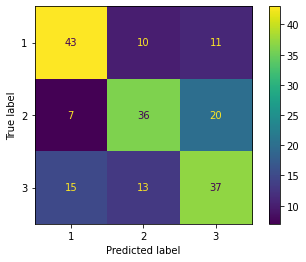

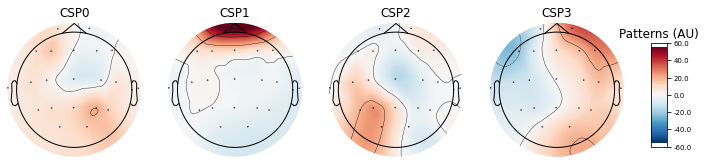




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.7188


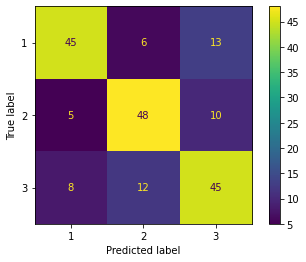

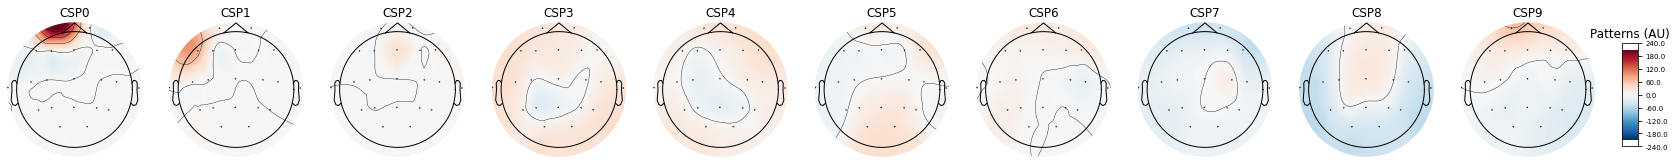




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.7382


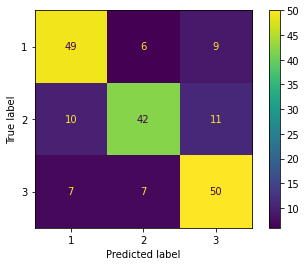

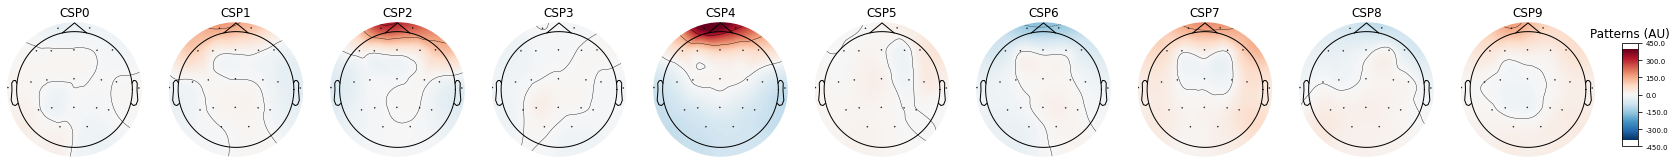

In [7]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]
best_found_filter_lower_bound = [2, 2, 1]
best_found_filter_upper_bound = [30, 30, 34]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/3/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_autofreqcsplda.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/3/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_autofreqcsplda.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/3/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_autofreqcsplda.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/3/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_autofreqcsplda.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    custom_filter = EpochsToFilteredData(start_offset = -1,
                                         data_tmin = 0.1,
                                         data_tmax = 0.6,
                                         sfreq= 200,
                                         filter_lower_bound= best_found_filter_lower_bound[i],
                                         filter_upper_bound= best_found_filter_upper_bound[i])
    
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('filter', custom_filter), ('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del best_found_filter_lower_bound
del best_found_filter_upper_bound
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, new session: LDA classifier

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The pipeline that is hyperparameter tuned is as follows
         - Filter -> CSP -> LDA
      - The following hyperparameters are tested
         - For the filter:
            - Lower threshold: 1 | 2 | 4 | 6 | 8 | 10 
            - Upper threshold: 26 | 28 | 30 | 32 | 34
         - For CSP:
            - Number of components: 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr
            - When using SVD optimizer, the tol is set to 0.0001, which is the default and was the best for all previous experiments
            - Shrinkage is fixed to None
            - the priors are initialized to a balanced 1/3
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [8]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
do_experiment = True # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get the labels
                        labels = mne_epochs.events[:, -1]
                        
                
                # Configure the pipeline components by specifying the default parameters
                custom_filter = EpochsToFilteredData(start_offset = -1,
                                                     data_tmin = 0.1,
                                                     data_tmax = 0.6,
                                                     sfreq= 200)
                
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('filter', custom_filter), ('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001],
                               "filter__filter_lower_bound": [1, 2, 4, 6, 8, 10],
                               "filter__filter_upper_bound": [26, 28, 30, 32, 34],
                               },
                              {"CSP__n_components": [4, 6, 10],
                               "LDA__solver": ["lsqr"],
                               "filter__filter_lower_bound": [1, 2, 4, 6, 8, 10],
                               "filter__filter_upper_bound": [26, 28, 30, 32, 34],
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           n_jobs= -1,
                                           return_train_score= True,
                                           error_score="raise")

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs.get_data(), y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/3/samesubject_differentsession/subject{subject_id}/gridsearch_autofreqcsplda.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del csp
                del lda
                del custom_filter
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset

Fitting 4 folds for each of 180 candidates, totalling 720 fits
Fitting 4 folds for each of 180 candidates, totalling 720 fits
Fitting 4 folds for each of 180 candidates, totalling 720 fits


#### Results

Remember the old results, where a fixed filter from 2Hz to 32Hz was used.

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                   |
|-------------|------------------------------------------|------------------------------------|----------------------------------------------|
| B           | 0.4500 +- 0.02576                        | 0.4677                             | CSP 10 components \| SVD LDA with 0.0001 tol |
| C           | 0.8177 +- 0.01940                        | 0.3587                             | CSP 10 components \| SVD LDA with 0.0001 tol |
| E           | 0.5525 +- 0.03678                        | 0.5518                             | CSP 10 components \| SVD LDA with 0.0001 tol |


The autofreq results are as follows:

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                                              |
|-------------|------------------------------------------|------------------------------------|-------------------------------------------------------------------------|
| B           | 0.6615 +- 0.0301                         | 0.6042                             | 2 - 30 Hz filter \| 4 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7171 +- 0.0349                         | 0.7188                             | 2 - 30 Hz filter \| 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7592 +- 0.0098                         | 0.7382                             | 1 - 34 Hz filter \| 10 CSP components \| LDA SVD solver with 0.0001 tol |




In [9]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/3/samesubject_differentsession/subject{subject_id}/gridsearch_autofreqcsplda.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {np.round(grid_search.best_score_, 4)} +- {np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 4)} with the following parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.4726 +- 0.0118 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'lsqr', 'filter__filter_lower_bound': 4, 'filter__filter_upper_bound': 26}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
160,13.481018,0.050836,3.244027,0.024111,10,lsqr,NaN,4,26,0.471354,...,0.462141,0.472609,0.011792,1,0.553913,0.540870,0.539531,0.568202,0.550629,0.011597
70,13.573985,0.085967,3.214213,0.006506,10,svd,0.0001,4,26,0.468750,...,0.462141,0.471958,0.011915,2,0.553913,0.540870,0.541268,0.568202,0.551063,0.011199
73,13.504062,0.095982,3.251465,0.025116,10,svd,0.0001,4,32,0.486979,...,0.454308,0.471922,0.040892,3,0.544348,0.543478,0.543875,0.562989,0.548672,0.008271
163,13.477918,0.062043,3.229354,0.025913,10,lsqr,NaN,4,32,0.486979,...,0.454308,0.471922,0.040892,3,0.545217,0.544348,0.543875,0.563858,0.549324,0.008404
161,13.475946,0.064703,3.219421,0.023364,10,lsqr,NaN,4,28,0.486979,...,0.456919,0.470633,0.025859,5,0.551304,0.543478,0.543875,0.566464,0.551280,0.009304
71,13.434026,0.111776,3.246105,0.015660,10,svd,0.0001,4,28,0.484375,...,0.456919,0.469982,0.025469,6,0.551304,0.543478,0.543875,0.567333,0.551498,0.009659
72,13.425880,0.081979,3.221657,0.016322,10,svd,0.0001,4,30,0.489583,...,0.462141,0.469974,0.034671,7,0.552174,0.546957,0.557776,0.567333,0.556060,0.007550
165,13.438549,0.094759,3.222050,0.014845,10,lsqr,NaN,6,26,0.471354,...,0.436031,0.469313,0.044825,8,0.554783,0.539130,0.554301,0.549088,0.549325,0.006295
75,13.499015,0.039382,3.238983,0.021071,10,svd,0.0001,6,26,0.471354,...,0.436031,0.469313,0.044825,8,0.554783,0.540000,0.554301,0.549088,0.549543,0.005945
162,13.438943,0.017239,3.286573,0.074912,10,lsqr,NaN,4,30,0.489583,...,0.462141,0.468670,0.034918,10,0.552174,0.546087,0.557776,0.567333,0.555842,0.007817




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
93,11.706314,0.118124,2.643121,0.025831,4,lsqr,NaN,1,32,0.372396,...,0.391645,0.363116,0.021514,171,0.400000,0.414783,0.395308,0.391833,0.400481,0.008751
3,11.812274,0.133515,2.703965,0.023058,4,svd,0.0001,1,32,0.372396,...,0.391645,0.363116,0.021514,171,0.399130,0.413913,0.396177,0.391833,0.400263,0.008297
4,12.762518,0.077959,2.687865,0.013858,4,svd,0.0001,1,34,0.359375,...,0.389034,0.359208,0.019850,173,0.406087,0.418261,0.395308,0.390964,0.402655,0.010559
31,14.191064,0.311108,3.022112,0.128617,6,svd,0.0001,1,28,0.341146,...,0.362924,0.359203,0.011625,174,0.392174,0.406957,0.423979,0.425717,0.412207,0.013693
94,11.694786,0.122075,2.632522,0.017746,4,lsqr,NaN,1,34,0.359375,...,0.386423,0.358556,0.018877,175,0.406087,0.419130,0.395308,0.390964,0.402873,0.010882
121,11.696794,0.072562,2.648598,0.023651,6,lsqr,NaN,1,28,0.338542,...,0.362924,0.358552,0.012646,176,0.393043,0.406087,0.423979,0.425717,0.412207,0.013470
30,11.592554,0.107143,2.656898,0.029238,6,svd,0.0001,1,26,0.341146,...,0.360313,0.357238,0.010323,177,0.391304,0.414783,0.423110,0.420504,0.412425,0.012561
120,11.631865,0.051109,2.673530,0.020062,6,lsqr,NaN,1,26,0.341146,...,0.360313,0.357238,0.010323,177,0.391304,0.413913,0.423110,0.421373,0.412425,0.012674
92,11.653096,0.095500,2.643020,0.007335,4,lsqr,NaN,1,30,0.315104,...,0.402089,0.352705,0.031568,179,0.367826,0.413913,0.394440,0.384014,0.390048,0.016726
2,11.740847,0.052973,2.705319,0.007766,4,svd,0.0001,1,30,0.315104,...,0.402089,0.351399,0.031658,180,0.366957,0.413913,0.393571,0.384014,0.389614,0.016962




In total there are 180 different configurations tested.
The best mean test score is 0.4726
There are 1 configurations with this maximum score
There are 32 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,32.000000,32.000000,32.000000,32.000000,32.0,32,16.0000,32.0,32.0,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
unique,NaN,NaN,NaN,NaN,3.0,2,1.0000,2.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,lsqr,0.0001,4.0,28.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,20.0,16,16.0000,16.0,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,13.456623,0.062379,3.233393,0.020086,NaN,NaN,NaN,NaN,NaN,0.472738,...,0.438561,0.462167,0.038866,16.250000,0.547717,0.528207,0.533911,0.543739,0.538393,0.010715
std,0.041175,0.024187,0.016933,0.012162,NaN,NaN,NaN,NaN,NaN,0.014140,...,0.014969,0.007015,0.009745,9.263177,0.007261,0.016280,0.021270,0.019732,0.014764,0.003893
min,13.388461,0.017239,3.207090,0.004637,NaN,NaN,NaN,NaN,NaN,0.442708,...,0.415144,0.453013,0.011792,1.000000,0.530435,0.492174,0.491746,0.511729,0.508043,0.005004
25%,13.425481,0.046317,3.223117,0.014851,NaN,NaN,NaN,NaN,NaN,0.466797,...,0.430157,0.455297,0.036008,8.000000,0.543696,0.520000,0.519331,0.523023,0.524340,0.008152
50%,13.450443,0.061874,3.228884,0.017250,NaN,NaN,NaN,NaN,NaN,0.475260,...,0.434726,0.462137,0.039829,16.000000,0.549130,0.533913,0.542572,0.549957,0.546499,0.010037
75%,13.489438,0.081090,3.244547,0.023551,NaN,NaN,NaN,NaN,NaN,0.486979,...,0.454308,0.469313,0.044431,23.500000,0.552609,0.541087,0.550608,0.559731,0.549706,0.013478





####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.8314 +- 0.0263 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001, 'filter__filter_lower_bound': 2, 'filter__filter_upper_bound': 34}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
69,13.432317,0.041575,3.268777,0.021756,10,svd,0.0001,2,34,0.796875,...,0.854167,0.831380,0.026260,1,0.841146,0.838542,0.845486,0.829861,0.838759,0.005705
159,13.416185,0.039562,3.230723,0.019192,10,lsqr,NaN,2,34,0.796875,...,0.854167,0.830729,0.026685,2,0.840278,0.838542,0.845486,0.829861,0.838542,0.005626
66,13.554072,0.100454,3.261836,0.032591,10,svd,0.0001,2,28,0.804688,...,0.848958,0.826823,0.024876,3,0.840278,0.843750,0.848958,0.831597,0.841146,0.006320
156,13.487268,0.076133,3.221545,0.025720,10,lsqr,NaN,2,28,0.804688,...,0.848958,0.826823,0.024876,3,0.841146,0.843750,0.848090,0.831597,0.841146,0.006045
155,13.521921,0.029355,3.234036,0.017751,10,lsqr,NaN,2,26,0.802083,...,0.848958,0.826172,0.021583,5,0.839410,0.847222,0.848958,0.831597,0.841797,0.006900
65,13.524335,0.059069,3.241283,0.024589,10,svd,0.0001,2,26,0.802083,...,0.848958,0.826172,0.021583,5,0.839410,0.847222,0.848958,0.831597,0.841797,0.006900
61,11.592114,0.076230,2.653309,0.043087,10,svd,0.0001,1,28,0.809896,...,0.833333,0.823568,0.013948,7,0.835069,0.837674,0.835938,0.824653,0.833333,0.005099
151,11.619771,0.083915,2.654535,0.029132,10,lsqr,NaN,1,28,0.809896,...,0.833333,0.823568,0.013948,7,0.835069,0.837674,0.835938,0.824653,0.833333,0.005099
158,13.459570,0.072233,3.232668,0.012233,10,lsqr,NaN,2,32,0.794271,...,0.841146,0.822917,0.029578,9,0.839410,0.836806,0.843750,0.828125,0.837023,0.005705
68,13.516999,0.073609,3.240287,0.030187,10,svd,0.0001,2,32,0.794271,...,0.841146,0.822917,0.029578,9,0.839410,0.837674,0.843750,0.828125,0.837240,0.005709




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
16,13.367999,0.056089,3.230971,0.020269,4,svd,0.0001,6,28,0.531250,...,0.567708,0.527344,0.027219,171,0.543403,0.585069,0.532118,0.552083,0.553168,0.019732
106,13.389993,0.070107,3.223570,0.021598,4,lsqr,NaN,6,28,0.531250,...,0.567708,0.527344,0.027219,171,0.543403,0.585938,0.532118,0.551215,0.553168,0.020100
107,13.391426,0.057093,3.246827,0.032866,4,lsqr,NaN,6,30,0.520833,...,0.567708,0.526693,0.026196,173,0.542535,0.588542,0.532118,0.549479,0.553168,0.021337
17,13.393740,0.053724,3.241041,0.019533,4,svd,0.0001,6,30,0.520833,...,0.567708,0.526042,0.027001,174,0.542535,0.587674,0.532986,0.548611,0.552951,0.020806
19,13.351440,0.061639,3.230296,0.007333,4,svd,0.0001,6,34,0.518229,...,0.559896,0.522135,0.024255,175,0.536458,0.580729,0.539062,0.554688,0.552734,0.017602
109,13.356786,0.034724,3.233764,0.013962,4,lsqr,NaN,6,34,0.518229,...,0.559896,0.522135,0.024255,175,0.536458,0.580729,0.539062,0.553819,0.552517,0.017582
108,13.366719,0.037754,3.241778,0.025411,4,lsqr,NaN,6,32,0.510417,...,0.565104,0.520182,0.029137,177,0.539062,0.589410,0.535590,0.552951,0.554253,0.021312
18,13.387982,0.059834,3.236338,0.004891,4,svd,0.0001,6,32,0.507812,...,0.562500,0.518880,0.028371,178,0.539062,0.588542,0.535590,0.552951,0.554036,0.020954
105,13.387309,0.047489,3.228236,0.010143,4,lsqr,NaN,6,26,0.513021,...,0.533854,0.511719,0.017710,179,0.543403,0.537326,0.527778,0.540799,0.537326,0.005919
15,13.443935,0.075332,3.250147,0.005752,4,svd,0.0001,6,26,0.513021,...,0.533854,0.511068,0.018722,180,0.541667,0.538194,0.527778,0.539931,0.536892,0.005404




In total there are 180 different configurations tested.
The best mean test score is 0.8314
There are 1 configurations with this maximum score
There are 20 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,20.000000,20.000000,20.000000,20.000000,20.0,20,10.0000,20.0,20.0,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
unique,NaN,NaN,NaN,NaN,1.0,2,1.0000,2.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,svd,0.0001,2.0,34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,20.0,10,10.0000,10.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,12.536336,0.060985,2.949988,0.024407,NaN,NaN,NaN,NaN,NaN,0.803125,...,0.834115,0.820833,0.020400,10.200000,0.836372,0.836328,0.841189,0.825564,0.834863,0.006058
std,0.967591,0.024373,0.297124,0.009682,NaN,NaN,NaN,NaN,NaN,0.009271,...,0.016429,0.005995,0.007953,5.925858,0.004294,0.006225,0.007021,0.004475,0.005025,0.001481
min,11.553717,0.022085,2.645094,0.006067,NaN,NaN,NaN,NaN,NaN,0.783854,...,0.804688,0.812500,0.009744,1.000000,0.828125,0.826389,0.831597,0.819444,0.827691,0.004089
25%,11.591536,0.041072,2.657901,0.018831,NaN,NaN,NaN,NaN,NaN,0.796875,...,0.820312,0.815104,0.013406,5.000000,0.833333,0.830512,0.835069,0.821181,0.829427,0.005099
50%,12.531997,0.060180,2.960599,0.024642,NaN,NaN,NaN,NaN,NaN,0.803385,...,0.837240,0.820964,0.019255,10.000000,0.838108,0.837674,0.840278,0.825087,0.835178,0.005705
75%,13.468390,0.078044,3.233010,0.029396,NaN,NaN,NaN,NaN,NaN,0.809896,...,0.848958,0.826172,0.026367,15.000000,0.839410,0.838542,0.848307,0.829861,0.838596,0.006900





####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.5545 +- 0.0337 with the following parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001, 'filter__filter_lower_bound': 1, 'filter__filter_upper_bound': 32}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
63,11.545817,0.112930,2.622415,0.008867,10,svd,0.0001,1,32,0.531250,...,0.590078,0.554484,0.033747,1,0.598782,0.564348,0.607826,0.590435,0.590348,0.016222
151,11.624292,0.040957,2.643407,0.019364,10,lsqr,NaN,1,28,0.546875,...,0.587467,0.554473,0.029997,2,0.605744,0.569565,0.613913,0.596522,0.596436,0.016689
153,11.591802,0.037681,2.636909,0.019117,10,lsqr,NaN,1,32,0.531250,...,0.587467,0.553831,0.033071,3,0.598782,0.565217,0.607826,0.589565,0.590348,0.015881
61,11.589553,0.128688,2.629161,0.001870,10,svd,0.0001,1,28,0.546875,...,0.587467,0.553821,0.029581,4,0.605744,0.569565,0.613043,0.597391,0.596436,0.016473
64,11.566310,0.089843,2.645407,0.013714,10,svd,0.0001,1,34,0.536458,...,0.582245,0.553175,0.028858,5,0.605744,0.560000,0.613043,0.586087,0.591219,0.020544
154,11.552564,0.044815,2.636410,0.017161,10,lsqr,NaN,1,34,0.536458,...,0.582245,0.553175,0.028858,5,0.606614,0.559130,0.613043,0.586087,0.591219,0.021032
60,11.632039,0.145123,2.626663,0.010686,10,svd,0.0001,1,26,0.541667,...,0.579634,0.549255,0.026879,7,0.597911,0.569565,0.602609,0.600870,0.592739,0.013484
150,11.648034,0.061064,2.635160,0.017587,10,lsqr,NaN,1,26,0.539062,...,0.579634,0.548604,0.027086,8,0.597911,0.569565,0.602609,0.600000,0.592521,0.013358
152,11.644785,0.085814,2.622164,0.010556,10,lsqr,NaN,1,30,0.531250,...,0.569191,0.547956,0.021475,9,0.602263,0.566087,0.606957,0.590435,0.591435,0.015825
62,11.577306,0.142034,2.631661,0.027345,10,svd,0.0001,1,30,0.531250,...,0.566580,0.547303,0.020850,10,0.602263,0.566957,0.606087,0.592174,0.591870,0.015255




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
9,13.441712,0.052884,3.297948,0.020669,4,svd,0.0001,2,34,0.468750,...,0.477807,0.476195,0.025298,171,0.477807,0.502609,0.528696,0.461739,0.492713,0.025369
5,13.422218,0.063735,3.227220,0.014162,4,svd,0.0001,2,26,0.442708,...,0.511749,0.474907,0.038390,172,0.475196,0.490435,0.506087,0.501739,0.493364,0.011944
95,13.537681,0.073926,3.225721,0.027189,4,lsqr,NaN,2,26,0.442708,...,0.511749,0.474907,0.038390,172,0.476066,0.489565,0.505217,0.502609,0.493364,0.011615
99,13.472453,0.045138,3.196480,0.015382,4,lsqr,NaN,2,34,0.468750,...,0.472585,0.474890,0.025316,174,0.478677,0.504348,0.526957,0.461739,0.492930,0.024820
8,13.526936,0.108108,3.246964,0.014843,4,svd,0.0001,2,32,0.471354,...,0.462141,0.472277,0.028427,175,0.477807,0.500000,0.528696,0.468696,0.493800,0.023142
97,13.493446,0.076197,3.209476,0.006019,4,lsqr,NaN,2,30,0.489583,...,0.451697,0.472265,0.029979,176,0.477807,0.499130,0.526957,0.467826,0.492930,0.022667
7,13.425967,0.062436,3.213975,0.007380,4,svd,0.0001,2,30,0.489583,...,0.451697,0.472265,0.029979,176,0.478677,0.496522,0.526957,0.466957,0.492278,0.022621
98,13.460206,0.039221,3.294949,0.067953,4,lsqr,NaN,2,32,0.468750,...,0.462141,0.471626,0.028471,178,0.476936,0.500870,0.526957,0.469565,0.493582,0.022477
96,13.483699,0.037956,3.230970,0.017300,4,lsqr,NaN,2,28,0.445312,...,0.496084,0.469683,0.032247,179,0.468233,0.491304,0.513913,0.499130,0.493145,0.016516
6,13.399975,0.047510,3.214975,0.011892,4,svd,0.0001,2,28,0.445312,...,0.496084,0.469683,0.032247,179,0.468233,0.491304,0.513043,0.500000,0.493145,0.016332




In total there are 180 different configurations tested.
The best mean test score is 0.5545
There are 1 configurations with this maximum score
There are 36 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,param_filter__filter_lower_bound,param_filter__filter_upper_bound,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,36.000000,36.000000,36.000000,36.000000,36.0,36,18.0000,36.0,36.0,36.000000,...,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
unique,NaN,NaN,NaN,NaN,3.0,2,1.0000,4.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,6.0,svd,0.0001,1.0,32.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,18.0,18,18.0000,20.0,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,12.420489,0.078372,2.897923,0.017861,NaN,NaN,NaN,NaN,NaN,0.532190,...,0.567813,0.542969,0.028951,18.277778,0.567958,0.565773,0.588454,0.565459,0.571911,0.014496
std,0.930450,0.037496,0.294319,0.007545,NaN,NaN,NaN,NaN,NaN,0.025653,...,0.020648,0.006193,0.008721,10.514238,0.030628,0.010815,0.020753,0.022018,0.018091,0.006635
min,11.544568,0.016187,2.622164,0.001870,NaN,NaN,NaN,NaN,NaN,0.492188,...,0.537859,0.534884,0.019418,1.000000,0.518712,0.543478,0.556522,0.533043,0.547725,0.004639
25%,11.591239,0.045470,2.636098,0.013027,NaN,NaN,NaN,NaN,NaN,0.501953,...,0.552872,0.538178,0.022002,9.750000,0.535248,0.559130,0.568696,0.540870,0.554189,0.009604
50%,11.646410,0.079974,2.649905,0.017630,NaN,NaN,NaN,NaN,NaN,0.536458,...,0.573107,0.541452,0.025244,18.500000,0.567450,0.565652,0.587391,0.562609,0.565558,0.015122
75%,13.436589,0.099842,3.221910,0.023755,NaN,NaN,NaN,NaN,NaN,0.555339,...,0.587467,0.547467,0.036790,27.250000,0.597911,0.576522,0.607826,0.586087,0.591219,0.016527





####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.3828


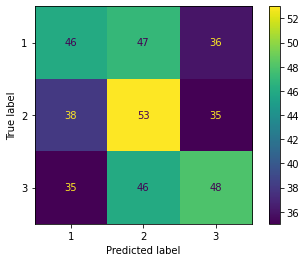

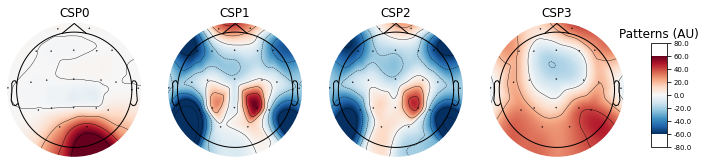




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.8177


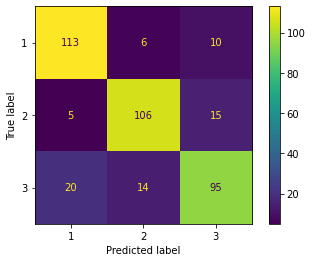

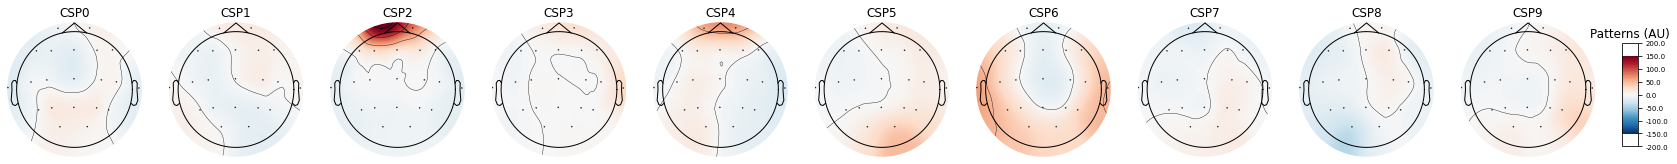




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.5443


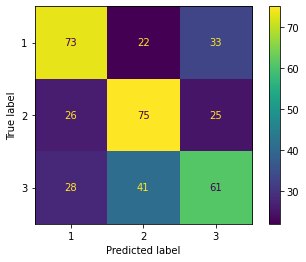

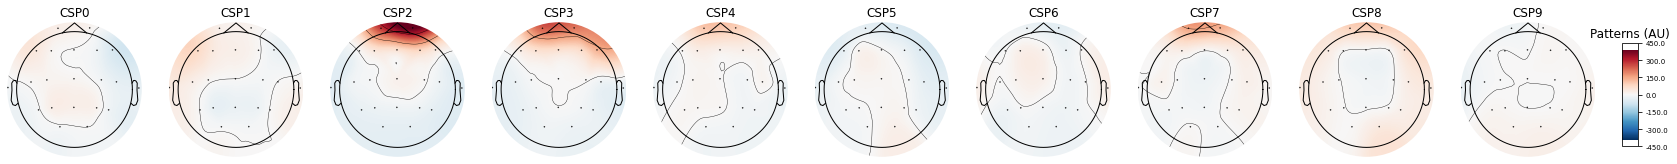

In [10]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]
best_found_filter_lower_bound = [2, 2, 1]
best_found_filter_upper_bound = [30, 30, 34]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/3/samesubject_differentsession/subject{subject_ids_to_test[i]}/testdata-x_autofreqcsplda.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/3/samesubject_differentsession/subject{subject_ids_to_test[i]}/testdata-y_autofreqcsplda.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/3/samesubject_differentsession/subject{subject_ids_to_test[i]}/traindata-x_autofreqcsplda.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/3/samesubject_differentsession/subject{subject_ids_to_test[i]}/traindata-y_autofreqcsplda.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    custom_filter = EpochsToFilteredData(start_offset = -1,
                                         data_tmin = 0.1,
                                         data_tmax = 0.6,
                                         sfreq= 200,
                                         filter_lower_bound= best_found_filter_lower_bound[i],
                                         filter_upper_bound= best_found_filter_upper_bound[i])
    
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('filter', custom_filter), ('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del best_found_filter_lower_bound
del best_found_filter_upper_bound
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy
